# Problem Statement

Consider a multiple measurement vector (MMV) linear regression model ${\bf Y}={\bf X}{\bf B}+{\bf W}$ where ${\bf X} \in \mathbb{R}^{n\times p}$ is a known design matrix and ${\bf B} \in \mathbb{R}^{p\times L}$ is an unknown row sparse matrix. The support of ${\bf B}$ denoted by $\mathcal{S}=\{k:{\bf B}[k,:]\neq {\bf 0}_{1\times L}\}$ satisfies $k_0=cardinality(\mathcal{S})\ll p$, i.e., only few rows of matrix ${\bf B}$  are non zero. In other words, ${\bf B}$ is row sparse.   ${\bf W} \in \mathbb{R}^{n \times L}$ is a noise vector (for theoretical purposes only)  with each entries $\mathcal{N}(0,\sigma^2)$ distributed. 

The problem we address here is the estimation of ${\bf B}$ when $k_0$ and $\sigma^2$ are both unknown. We consider a high dimensional scenario where $n\ll p$. Under these constraints, it is difficult to estimate ${\bf B}$ and $ \mathcal{S}$ with finite sample guarantees.  Most (not all) popular sparse recovery algorithms including SOMP (simultaneous OMP), matrix versions of LASSO  etc. can deliver estimation  with theoretical (especially restricted isometry property ) guarantees require $\textit{a priori}$ knowledge of $k_0$ and/or $\sigma^2$. Algorithms that does not require such a priori information are SPICE, SBL etc. 

In our 2018 ICML paper http://proceedings.mlr.press/v80/kallummil18a.html we proposed residual ratio thresholding (RRT) as a tool to estimate ${\bf B}$ using OMP without requiring $\textit{a priori}$ knowledge of $k_0$ and/or $\sigma^2$ in a single measurement vector setting ($L=1$). This concept was later extended to multiple measurement vector scenario in a recent article (https://arxiv.org/pdf/1912.08637.pdf under review in IEEE TSP). There we discussed how to operate SOMP without requiring $\textit{a priori}$ knowledge of $k_0$ and/or $\sigma^2$.
Here, we illustrate  the techniques discussed in this paper. 

# Concept  of RRT

Suppose we are given an ordered sequence of support estimates $\mathcal{S}_1,\mathcal{S}_2...\mathcal{S}_{k_{max}}$ such that  a $card(\mathcal{S}_k)=k$ and $\mathcal{S}_k\subset \mathcal{S}_{k+1}$.  Corresponding to each support $\mathcal{S}_k$, one can compute the corresponding least squares residuals as ${\bf R}^k=({\bf I}_{n}-{\bf P}(\mathcal{S}_k)){\bf Y}$, where ${\bf P}(\mathcal{S}_k)$ is the projection onto the subspace spanned by the columns in ${\bf X}[:,\mathcal{S}_k]$ and ${\bf I}_n$ is the $n \times n$ identity matrix. The corresponding residual ratios are defined as $$RR(k)=\dfrac{\|{\bf R}^k\|_F}{\|{\bf R}^{k-1}\|_F}$$., where $\|\|_F$ is the Frobenius norm.  

This statistic satisfies some interesting properties. For starters, $$0\leq RR(k)\leq 1$$

Under appropriate conditions on the matrix ${\bf X}$, SNR and sparsity $k_0$, many algorithms can generate support estimate sequences that satisfy $\mathcal{S}_{k_0}=\mathcal{S}$, the true unknown support of ${\bf B}$. If those conditions are true then 

$$1). \ \ RR(k_0)\rightarrow 0  \ \text{as} \ \sigma^2\rightarrow 0$$.  

$$2). \ \ \mathbb{P}(RR(k)>\Gamma_{RRT}^{\alpha}(k),\ \text{for all} \ k=k_0+1,....k_{max})>1-\alpha$$

where $$\Gamma_{RRT}^{\alpha}(k)=\sqrt{\mathbb{F}_{\dfrac{(n-k) \times L}{2},\dfrac{L}{2}}^{-1}\left(\frac{\alpha}{(p-k+1)kmax}\right)}$$
is a sequence of RRT thresholds. $\mathbb{F}_{a,b}(x)$ is the CDF of a Beta random variable with parameters $a$ and $b$ and $F^{-1}$ is the inverse function of $\mathbb{F}$.  

Properties 1 and 2 of $RR(k)$ means that the RRT estimate of sparsity given by $$k_{RRT}=\max\{k:RR(k)\leq \Gamma_{RRT}^{\alpha}(k)\}$$ will be equal to true unknown sparsity $k_0$ and $\mathcal{S}_{k_{RRT}}$ will be equal to the true unknown support $\mathcal{S}$ at high enough SNR. 


# Usage

In codes (nfeatures=p,nchannels=L,nsamples=n)
${\bf Given}$:  Y and X. We assume that X has unit $l_2$ norm columns. 

${\bf Step\  1\ :}$ mmv=multiple_measurement_vector()

${\bf Step \ 2\ :}$ estimate_support_dict=mmv.compute_signal_and_support(X,Y,algorithm='SOMP',alpha_list=[0.1])

${\bf Inputs: }$ algorithm has to be 'SOMP'.
alpha_list=[$\alpha_1$,$\alpha_2$,...] the set of RRT thresholds alpha for which the estimates of ${\bf B}$ and support $\mathcal{S}$ is to be computed. 

${\bf Outputs:}$  estimate_support_dict is a dictionary with keys $\alpha$ and values another dictionary dict. dict['support_estimate'] and dict['signal_estimate'] give the  estimates of $\mathcal{S}$ and ${\bf B}$ corresponding to the RRT threshold $\alpha$.


# How to use functions other than SOMP in  RRT framework. 

Any algorithm called 'Alg' that can deliver a support estimate of the form $\mathcal{S}_k=Alg(X,Y,k)$ with $card(\mathcal{S}_k)=k$ can be used in RRT. Please construct a new function $$\text{res_ratio},\text{ordered_support_estimate_sequence}=\text{self.Alg_run()}$$
in multiple_measurement_vector.py This can be achieved as follows. 


${\bf Step 1}$: Generate $\mathcal{S}_k=Alg(X,Y,k)$ for k=1,2,..,$k_{max}$. We typically set $k_{max}=\min\left(nfeatures,0.5(nsamples+1)\right)$. 

${\bf Step 2:}$ The support sequence generated by Alg may not be monotonically increasing, i.e., $\mathcal{S}_k\subset \mathcal{S}_{k+1}$. Convert non monotonic support sequence to monotonic support sequence 

    a). ordered_support_estimate_sequence= self.generate_ordered_sequence(support_estimate_sequence,kmax)
    
${\bf Step 3:}$  Generate residual ratios corresponding to the ordered_support_estimate_sequence. 

    a). res_ratios=self.res_ratios_from_ordered_sequence(ordered_support_estimate_sequence,X,Y)
    


# Other utility functions

    1). X,Y,Beta_true,support_true,noisevar=mmv.generate_random_example(nsamples=32,nfeatures=64,nchannels=10,sparsity=3,SNR_db=20)
    
This function generates a linear regression model using Gaussian matrices which is further normalized to have $l_2$ columns, a sparse vector with non zero entries randomly assigned $\pm1$  and Gaussian noise of noise variance determined by the required SNR. 

    2). support_error,fro_error=mmv.compute_error(support_true,support_estimate,
                                                 Beta_true,Beta_estimate)
                                                
This function computes the support recovery error (=1 if support estimate!= support_true else 0) and the estimation error between ${\bf B}$ and its estimate using Frobenius norm.  

    3). support_est,Beta_est=mmv.SMP_prior_sparsity(X,Y,sparsity=len(support_true))
    
This function computes SOMP support estimate when provided with the apriori value of sparsity level $k_0$. Good baseline. 
                    

###  Example: Generate a sparse regression problem


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from codes.multiple_measurement_vector import multiple_measurement_vector


In [2]:
mmv=multiple_measurement_vector();
X,Y,Beta_true,support_true,noisevar=mmv.generate_random_example(nsamples=32,nfeatures=64,nchannels=5,sparsity=3,SNR_db=20)
print('Unknown sparse vector Beta is')
print(Beta_true)
print('Support of Beta is')
print(support_true)

Unknown sparse vector Beta is
[[-1.  1. -1.  1.  1.]
 [-1. -1. -1.  1.  1.]
 [-1.  1.  1. -1. -1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0

### Example: RRT estimation

In [3]:
results_somp_dict=mmv.compute_signal_and_support(X=X,Y=Y,algorithm='SOMP',alpha_list=[0.1])
print('True_support')
print(support_true)
print('Estimated_support:SOMP')
print(results_somp_dict[0.1]['support_estimate'])
Beta_est_somp=results_somp_dict[0.1]['signal_estimate']

True_support
[0, 1, 2]
Estimated_support:SOMP
[0, 2, 1]


# Evaluating performance. 

We compare the performance of SOMP  operated using RRT against a simple baseline. An SOMP algorithm operated using a priori knowledge of sparsity $k_0$. Except at low SNR, SOMP operated using RRT matches the support aware SOMP estimator. In our papers, we compare RRT with SOMP with noise statistic aware schemes also.   IN most of our experiments, we found that the performance GAP between SOMP with a priori known sparsity and noise variance and SOMP operated using RRT is minimal. 

In [8]:
SNR_db=np.linspace(-10,30,10)
FRO_ERROR_SOMP=np.zeros(10);FRO_ERROR_BASELINE=np.zeros(10)
SUPPORT_ERROR_SOMP=np.zeros(10);SUPPORT_ERROR_BASELINE=np.zeros(10)
num_iter=1000; # number of montecarlo iterations for each example. 
nsamples=32;nfeatures=64;sparsity=3;nchannels=10;


for s in np.arange(len(SNR_db)):
    snr_db=SNR_db[s]
    fro_error_somp=0;fro_error_baseline=0;
    support_error_somp=0;support_error_baseline=0;
    for num in np.arange(num_iter):
        X,Y,Beta_true,support_true,noisevar=mmv.generate_random_example(nsamples=nsamples,nfeatures=nfeatures,
                                                                        nchannels=nchannels,
                                                                        sparsity=sparsity,SNR_db=snr_db)
        
        results_somp_dict=mmv.compute_signal_and_support(X=X,Y=Y,algorithm='SOMP',alpha_list=[0.1])
        support_estimate_somp=results_somp_dict[0.1]['support_estimate']
        Beta_est_somp=results_somp_dict[0.1]['signal_estimate']
        support_error,fro_error=mmv.compute_error(support_true=support_true,support_estimate=support_estimate_somp,
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_somp)
        fro_error_somp+=fro_error;support_error_somp+=support_error
        
        support_estimate_baseline,Beta_est_baseline=mmv.SOMP_prior_sparsity(X=X,Y=Y,sparsity=len(support_true))
        support_error,fro_error=mmv.compute_error(support_true=support_true,support_estimate=support_estimate_baseline,
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_baseline)
        fro_error_baseline+=fro_error;support_error_baseline+=support_error;
        
    FRO_ERROR_SOMP[s]=fro_error_somp/num_iter;FRO_ERROR_BASELINE[s]=fro_error_baseline/num_iter
    SUPPORT_ERROR_SOMP[s]=support_error_somp/num_iter;
    SUPPORT_ERROR_BASELINE[s]=support_error_baseline/num_iter



Text(0, 0.5, 'support_recovery_error')

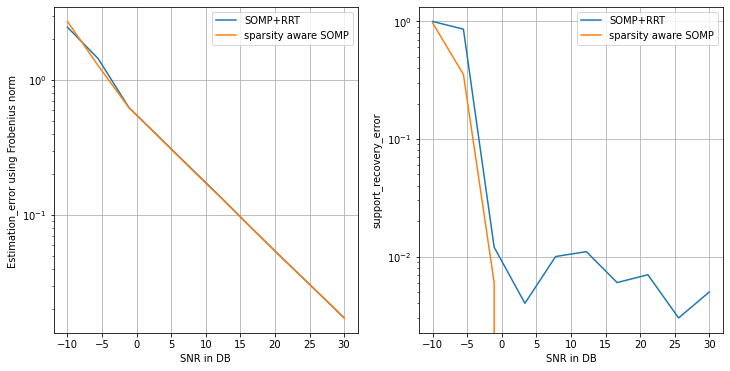

In [9]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogy(SNR_db,FRO_ERROR_SOMP,label='SOMP+RRT')
plt.semilogy(SNR_db,FRO_ERROR_BASELINE,label='sparsity aware SOMP')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('Estimation_error using Frobenius norm ')  

plt.subplot(1,2,2)
plt.semilogy(SNR_db,SUPPORT_ERROR_SOMP,label='SOMP+RRT')
plt.semilogy(SNR_db,SUPPORT_ERROR_BASELINE,label='sparsity aware SOMP')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('support_recovery_error')  